In [11]:
import numpy as np
import cv2
import glob

#Create function to load and rescale to 128x128 and greyscale
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    img = np.reshape(img, (128, 128))
    return img

# Create function to load the data
# [0] is the label // [1] is the image itself
def load_dataset(path):
    dataset = [(int(img_path[-6]), load_img(img_path)) for img_path in glob.glob(path)]
    return dataset

In [12]:
train_set = load_dataset('./train/*.png')
test_set = load_dataset('./test/*.png')

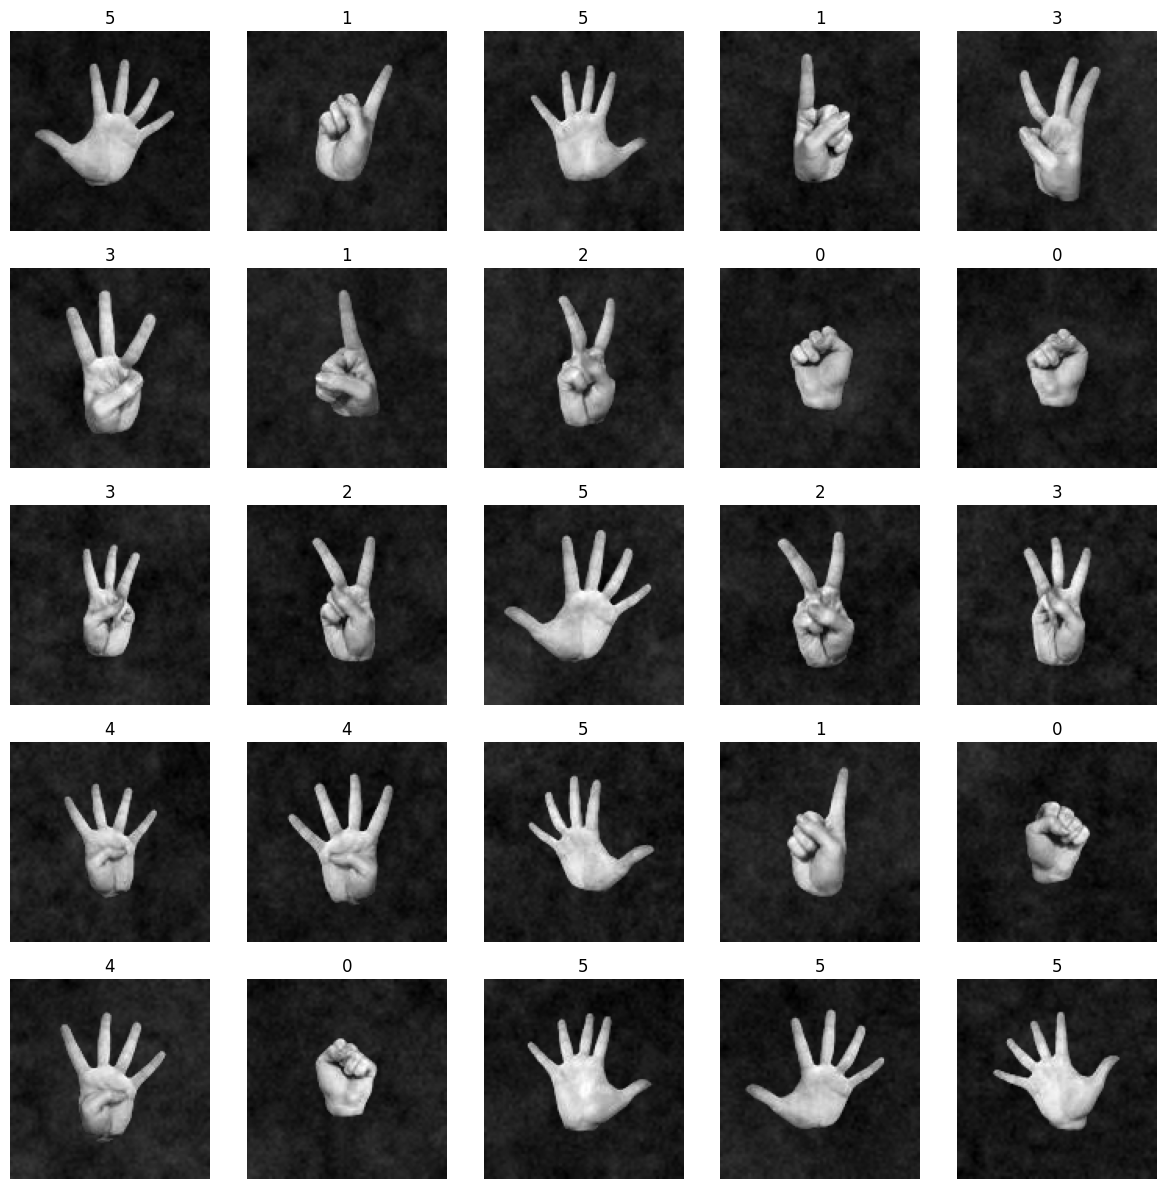

In [13]:
import matplotlib.pyplot as plt
import random

# Test To make sure the dataset has been created correctly and photos have the correct labels
grid_size = 5
_, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = [y for x in axes for y in x]

for (i, (label, img)) in enumerate(random.sample(train_set, grid_size**2)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Process the actual photos
IMAGE_SIZE = 128

# Function to process each image by adding different filters and affects to make it the easiest fir the CNN to read
def process_image(img, thresh_low = 80, thresh_high = 255):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))                         # Resize image to fixed size
    img = cv2.GaussianBlur(img, (5, 5), 0)                                  # Smooth image with Gaussian blur
    _, img = cv2.threshold(img, thresh_low, thresh_high, cv2.THRESH_BINARY) # Convert to black & white
    im_floodfill = img.copy()                                               # Copy image for flood fill operation
    h, w = img.shape[:2]                                                    # Get image height and width
    mask = np.zeros((h+2, w+2), np.uint8)                                   # Create mask for flood fill
    cv2.floodFill(im_floodfill, mask, (0,0), 255)                           # Fill background starting from top-left
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)                        # Invert flood-filled image
    img = img | im_floodfill_inv                                            # Combine to fill holes inside the finger
    img = img/255                                                           # Normalise pixel values (0–1)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))                      # Reshape to (size, size, 1) for CNN input
    return img

def process_dataset(dataset):
    dataset = [(label, process_image(img)) for (label, img) in dataset]
    return dataset

In [15]:
training_set = process_dataset(train_set)
test_set = process_dataset(test_set)

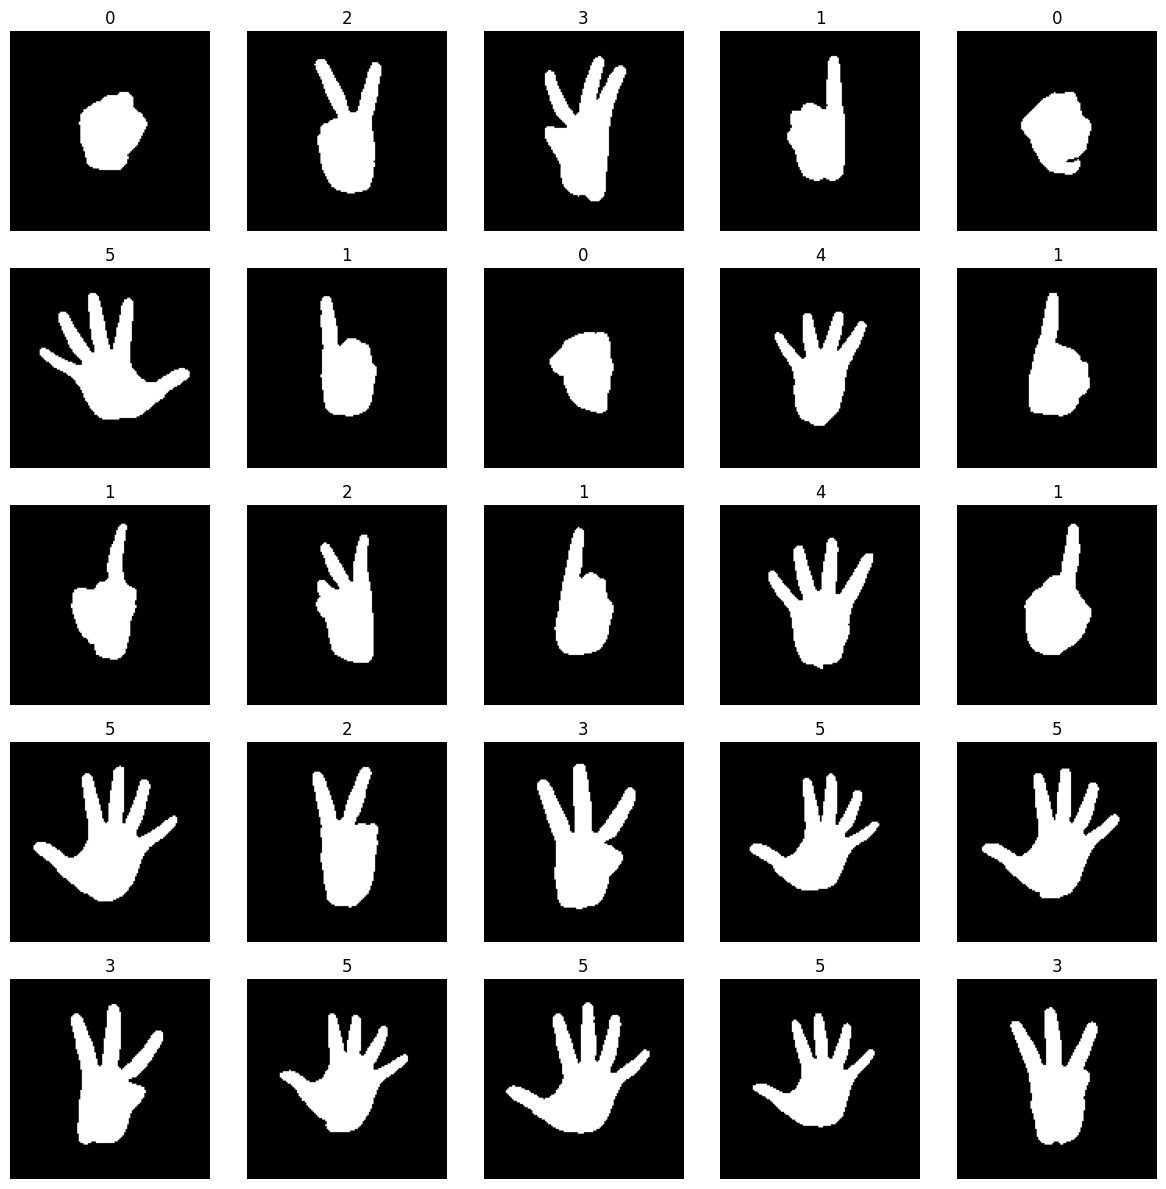

In [16]:
# Test to see if the images have changed
grid_size = 5
_, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = [y for x in axes for y in x]

for (i, (label, img)) in enumerate(random.sample(training_set, grid_size**2)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
from tensorflow.keras.utils import to_categorical
import keras

# Splitting The Data into arrays that Keras can understand for training and testing
# Only takes the img from the training set
X_train = np.array([img for (_, img) in training_set])

# Encode the labels into 6 classes
# 0 = 0 fingers // 1 = 1 finger etc...
Y_train = to_categorical([label for (label, _) in training_set], num_classes = 6)

# Repeats for the test img and labels
X_test = np.array([img for (_, img) in test_set])
Y_test = to_categorical([label for (label, _) in test_set], num_classes = 6)

In [ ]:
# Data Augmentation
# As real time inputs from video are going to have different lighting and shadows and angles i need to alter the images so it helps with generalization in real time at the cost of a slight decrease in accuracy while training
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
    rotation_range= 45,            # slight rotate up to 45 degrees (account for fingers at different angles other than centered)
    zoom_range = 0.2,              # 20% zoomed in/out (account for finger being close or further away)
    width_shift_range = 0.05,      # shifted on the vert or horz by 5% (account for hands not being near the center of thr screen)
    height_shift_range = 0.05,     # ^^^^^^^^^
    shear_range = 0.1,             # applies shear transformation, slanting the image (accounts for angle of hand)
    horizontal_flip = False,       # stops images from being flipped (prevent left hands and right hands flipping)
    fill_mode = "nearest"          # fills edges with the closest value to get smoother images
    )

